## Analysis of holtankoljak.hu station and gas price data

In [170]:
import pandas as pd
import numpy as np

from ast import literal_eval
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import stylecloud
from IPython.display import Image, display

import warnings
warnings.filterwarnings('ignore')

def distribution_numerics_sns(data, i):    

    plt.figure(figsize = (9, 4))
    sns.distplot(data[i], kde = False, bins = 40, 
                    hist_kws = {'edgecolor' : 'black', 'linewidth' : 1})

    plt.title('Distribution of ' + i)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show() 


BOXPLOT_PROPS = {
    'boxprops':{'edgecolor':'black', 'linewidth' : 1},
    'flierprops':{'markerfacecolor':'black', 'markeredgecolor':'darkgray', 'marker' : 'x'},
    'medianprops':{'color':'black', 'linewidth' : 1},
    'whiskerprops':{'color':'black', 'linewidth' : 1},
    'capprops':{'color':'black', 'linewidth' : 1}
}
   
    
def boxplot_sns_price_cat(data, x, y):

    data[y] = data[y].astype(str)    
    order = data.loc[:,[x, y]].groupby([y]).median().sort_index()

    plt.figure(figsize = (10, 5))
    sns.boxplot(data = data, x = x, y = y, color = 'blue', fliersize = 2, 
                **BOXPLOT_PROPS, order = order.index)
    plt.ylabel('Vételár HUF')
    plt.xlabel(None)
    plt.xticks(rotation = 90, ha = 'center')
    plt.title('Distribution of asking price with regards to ' + y)
    plt.show()

def scatter_sns(data, x, y):
    plt.figure(figsize = (9, 5))
    sns.scatterplot(data = data, x = x, y = y, size = 3/4, edgecolor = 'k', linewidth = 1/3, color = 'blue', legend = False)
    plt.title('Relationship between ' + x + ' and ' + y)
    plt.show() 

def plot_stations(df, color_by):
    
    df['size_for_plot'] = 10

    fig = px.scatter_mapbox(df, lat = 'LAT', lon = 'LON', hover_name = 'address', 
                            center = {"lat": df['LAT'].mean(), "lon": df['LON'].mean()}, 
                            hover_data = ['link', 'Gázolaj', 'Prémium Gázolaj', '95-ös Benzin E10'], color = color_by,
                            title = 'Kutak elhelyezkedése',
                            zoom = 6, size_max = 5, size = 'size_for_plot', 
                            mapbox_style = 'carto-positron', width = 950, height = 750)
    fig.show()

    df.drop('size_for_plot', 1, inplace = True)
    

def plot_corr(df, numerics):
    
    fig, ax = plt.subplots(figsize = (14, 6))
    sns.heatmap(df[numerics].corr(), ax = ax, cmap = 'coolwarm', center = 0, 
                annot = True, fmt = '.2g', annot_kws={'size' : 8})
    plt.title('Correlations\n')
    plt.show()

In [190]:
data = pd.read_csv('data/scraped_data.csv')
data.head(3)

,link,address,geo_location,services,open_hours,prices
0,https://holtankoljak.hu/omv_cece_vasutu2,"Cece, Vasút u. 2.","46.77132797,18.62500381","['kávé', ' bankkártya elfogadás', ' WC', ' ker...","['Hétfő:06:00 - 20:00', 'Kedd:06:00 - 20:00', ...","{'Gázolaj': 'Nem ismert', 'Prémium Gázolaj': '..."
1,https://holtankoljak.hu/mol_pecs_versenyutca1,"Pécs, Verseny utca 1.","46.06662369,18.23132706","['autópálya-matrica', ' mobiltelefon egyenlegf...","['Hétfő:06:00 - 22:00', 'Kedd:06:00 - 22:00', ...","{'Lpg': '325.9,- Ft', 'Cng': '435.0,- Ft /kg20..."
2,https://holtankoljak.hu/mol_kecskemet_kiskunfe...,"Kecskemét, Kiskunfélegyházi út (Szegedi út)","46.88214874,19.70771980","['HU-GO feltöltés', ' kenőolaj', ' UTA-kártya'...","['Hétfő:06:00 - 22:00', 'Kedd:06:00 - 22:00', ...","{'95-ös Benzin E10': '479.9,- Ft', 'Prémium Gá..."


### Clean up features

In [191]:
### GEO COORDS

data[['LAT', 'LON']] = data['geo_location'].str.split(',', expand = True).astype(float)
data.drop('geo_location', 1, inplace = True)

In [192]:
### PRICES

gas_types = pd.json_normalize(data['prices'].apply(eval))
gas_types.replace({'Nem ismert' : np.nan}, inplace = True)

NaN_count = gas_types.isnull().sum() / gas_types.shape[0]
keep_cols = NaN_count[NaN_count <= .75]
print('Keeping the following gas types:', keep_cols.index.tolist())

gas_types = gas_types[keep_cols.index.tolist()]

for i in gas_types.columns:
    gas_types[i] = gas_types[i].str.replace(',- Ft', '').astype(float)

data = pd.concat([data, gas_types], 1).drop(['prices'], 1)
data['Num_of_Gas_Types'] = 5 - gas_types.isnull().sum(axis=1)

Keeping the following gas types: ['Gázolaj', 'Prémium Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5']


In [195]:
### OPEN HOURS

hours = data['open_hours'].apply(eval).apply(pd.Series)
hours.columns = ['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap']

for i in hours.columns:

    hours[i] = hours[i]\
                    .str.replace('Hétfő:', '')\
                    .str.replace('Kedd:', '')\
                    .str.replace('Szerda:', '')\
                    .str.replace('Csütörtök:', '')\
                    .str.replace('Péntek:', '')\
                    .str.replace('Szombat:', '')\
                    .str.replace('Vasárnap:', '')\
                    .str.replace('0-24 óráig', '00:00 - 24:00')\
                    .str.replace('00:00 - 23:59', '00:00 - 24:00')\
                    .str.replace('00:00 - 00:00', '00:00 - 24:00')\
                    .str.replace('Zárva', '00:00 - 00:00')\
                    .str.replace('06:00 - 02:00', '06:00 - 26:00')\
                    .str.replace('06:00 - 00:00', '06:00 - 24:00')

def calc_hours_open(_time):
    
    OPEN = _time.split(' - ')[0]
    OPEN_CONV = int(OPEN.split(':')[0]) + int(OPEN.split(':')[1]) / 60

    CLOSE = _time.split(' - ')[1]
    CLOSE_CONV = int(CLOSE.split(':')[0]) + int(CLOSE.split(':')[1]) / 60

    HOURS_OPEN = CLOSE_CONV - OPEN_CONV

    return HOURS_OPEN

for i in hours.columns:
    hours[i] = hours[i].apply(lambda x: calc_hours_open(x))

data = pd.concat([data, hours], 1).drop(['open_hours'], 1)
data = data[data['Hétfő'] != 0]

In [203]:
data[hours.columns].describe(percentiles = [.1, .25, .5, .75, .9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
Hétfő,1304.0,18.378630,4.497326,8.0,14.0,15.0,16.0,24.0,24.0,24.0
Kedd,1304.0,18.378246,4.497891,8.0,14.0,15.0,16.0,24.0,24.0,24.0
Szerda,1304.0,18.376789,4.499991,8.0,14.0,15.0,16.0,24.0,24.0,24.0
Csütörtök,1304.0,18.382157,4.496894,8.0,14.0,15.0,16.0,24.0,24.0,24.0
Péntek,1304.0,18.371345,4.496675,8.0,14.0,15.0,16.0,24.0,24.0,24.0
Szombat,1304.0,18.161682,4.871010,0.0,14.0,14.5,16.0,24.0,24.0,24.0
Vasárnap,1304.0,18.142510,5.185215,0.0,12.0,14.0,16.0,24.0,24.0,24.0


In [209]:
data['Open_7-24'] = 0
data.loc[data[hours.columns].eq(24).all(1), 'Open_7-24'] = 1

In [214]:
### LINK

brands = pd.DataFrame(data['link'].str.replace('https://holtankoljak.hu/', '').str.split('_', expand = True)[0])

brand_mapper = {'mobil' : 'mobil-petrol', 'mol-partner' : 'mol', 'oil' : 'oil!'}
brands[0].replace(brand_mapper, inplace = True)

brand_keep = brands[0].value_counts().head(10).index.tolist()
brands.loc[~brands[0].isin(brand_keep), 0] = 'magan'
brands.columns = ['brand']

data = pd.concat([data, brands], 1)

In [215]:
### BUDAPEST or NOT

data['Budapest'] = 0
data.loc[data['link'].str.contains('budap'), 'Budapest'] = 1
#data.drop('link', 1, inplace = True)

In [216]:
### AUTOPALYA or not

data['Highway'] = 0
data.loc[(data['address'].str.lower().str.contains('km')) | 
          (data['address'].str.lower().str.contains('autópálya')) | 
          (data['address'].str.lower().str.contains('m1|m2|m2|m4|m5|m6|m7')), 'Highway'] = 1
#data.drop('address', 1, inplace = True)

In [217]:
### SERVICES

data['Num_of_Services'] = data['services'].apply(eval).apply(lambda x: len(set(x)))
all_services = data['services'].apply(eval).apply(lambda x: [i.strip() for i in x if i != '']).tolist()

all_services_flat = [item for sublist in all_services for item in sublist]
all_services_set = list(set(all_services_flat))

print('Number of total unique services available:', len(all_services_set))

Number of total unique services available: 48


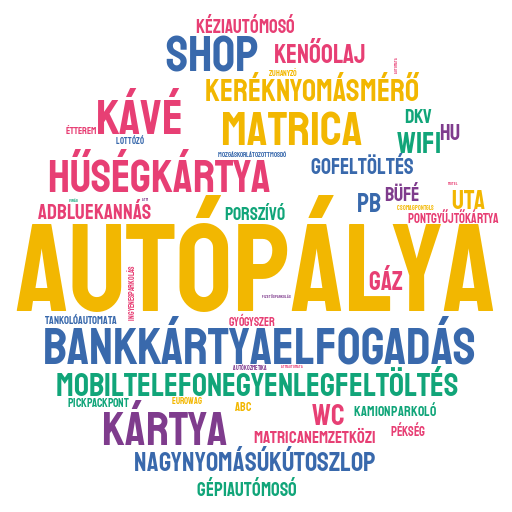

In [10]:
wc_data = ' '.join([i.replace(' ', '') for i in all_services_flat])

stylecloud.gen_stylecloud(wc_data, max_words = 750, max_font_size = 350, icon_name = 'fas fa-circle',
                          output_name = 'data/services.png', collocations = False)

display(Image(filename = 'data/services.png', width = 450))

## Distributions

In [148]:
plot_stations(data, 'brand')

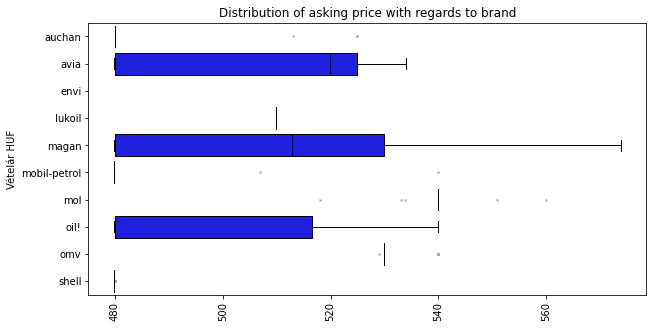

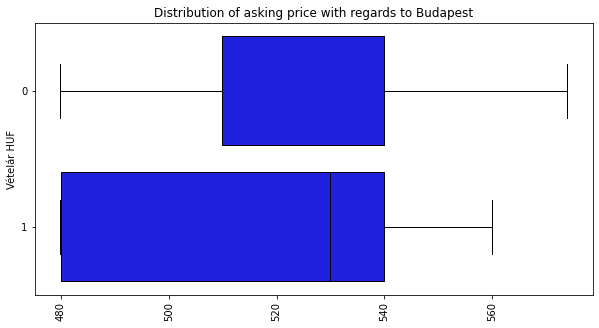

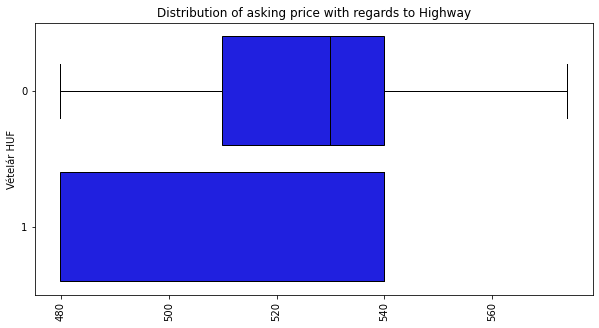

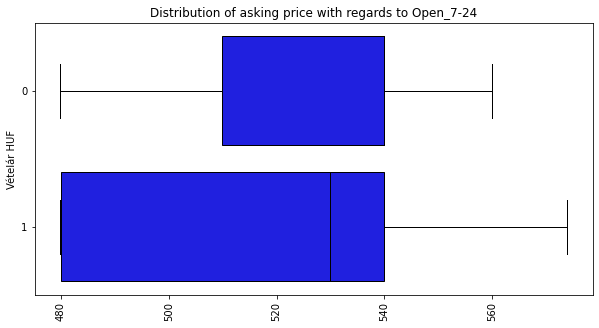

In [218]:
for i in ['brand', 'Budapest', 'Highway', 'Open_7-24']:
            boxplot_sns_price_cat(data, 'Prémium Gázolaj', i)

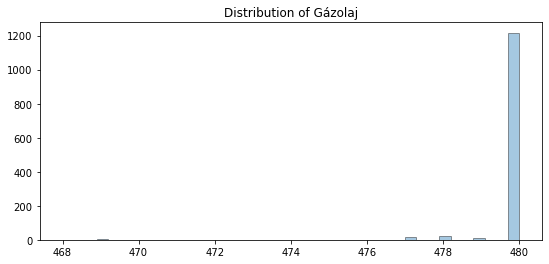

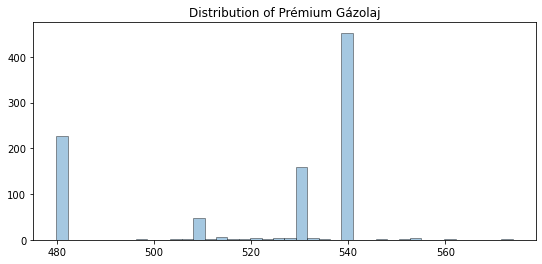

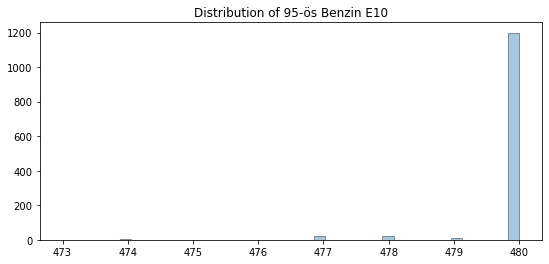

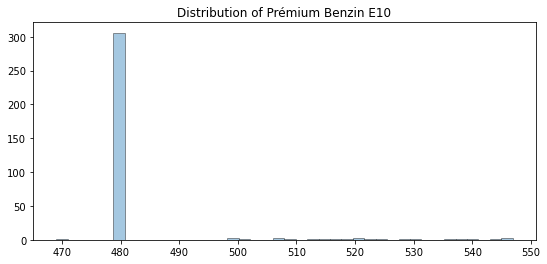

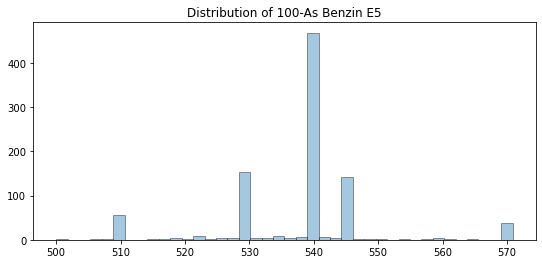

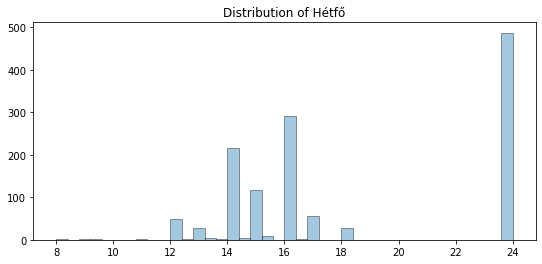

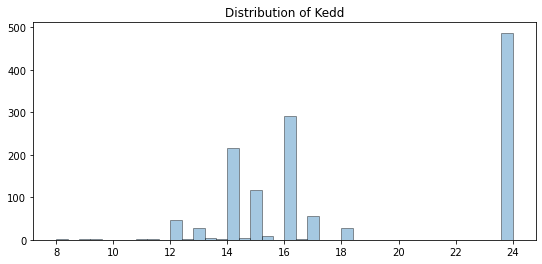

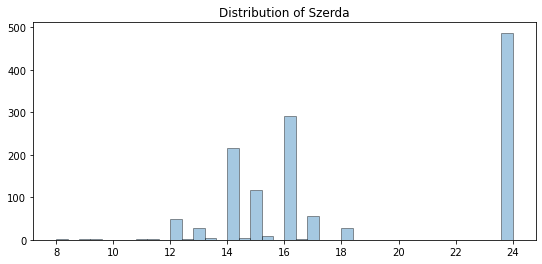

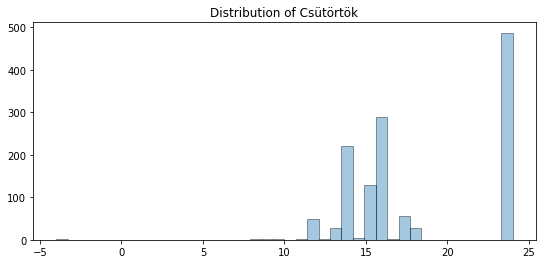

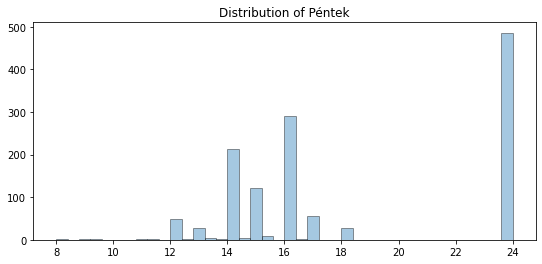

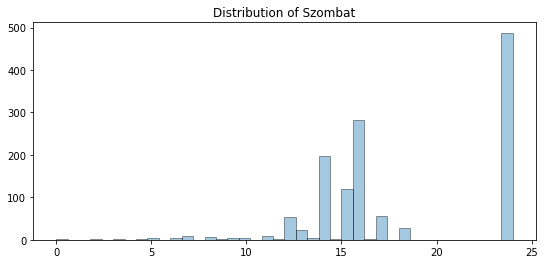

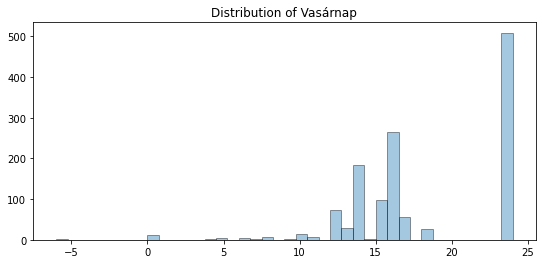

In [150]:
for i in ['Gázolaj', 'Prémium Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5', 
            'Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap']:
       distribution_numerics_sns(data, i)

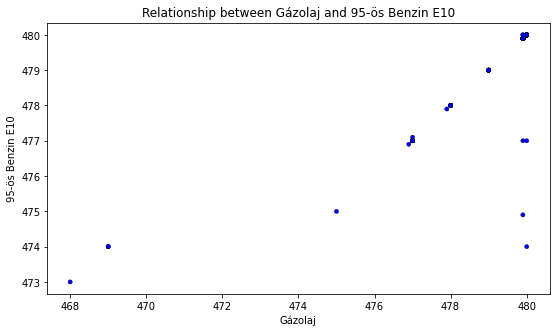

In [151]:
scatter_sns(data, 'Gázolaj', '95-ös Benzin E10')

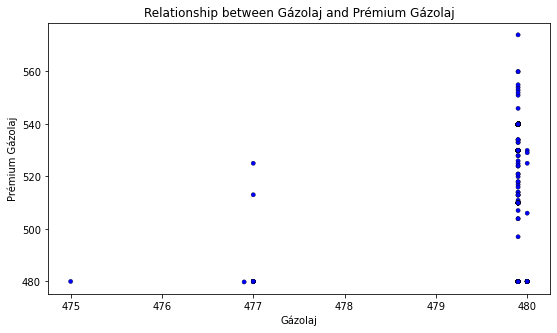

In [152]:
scatter_sns(data, 'Gázolaj', 'Prémium Gázolaj')

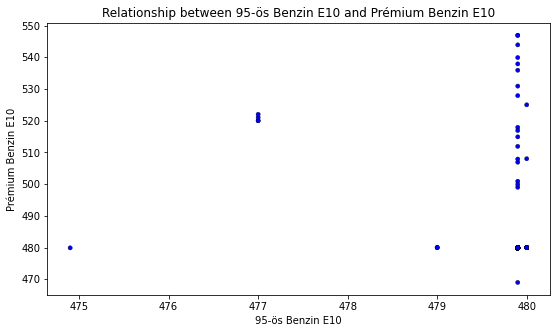

In [153]:
scatter_sns(data, '95-ös Benzin E10', 'Prémium Benzin E10')

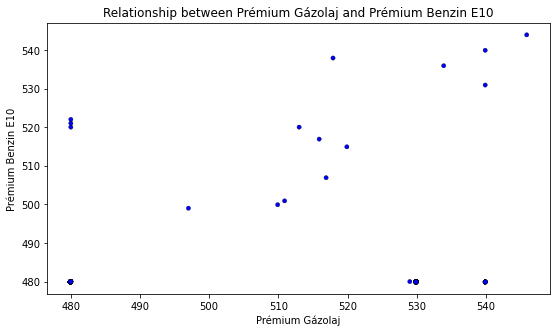

In [154]:
scatter_sns(data, 'Prémium Gázolaj', 'Prémium Benzin E10')

### Correlation

In [221]:
for i in ['Open_7-24', 'Budapest', 'Highway']:
    data[i] = data[i].astype(int)

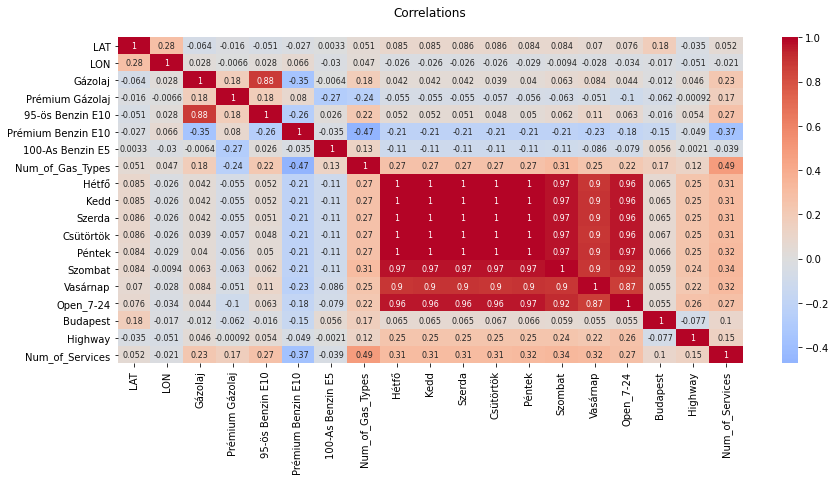

In [222]:
plot_corr(data, data.select_dtypes(exclude = 'O').columns)

## Modeling Gasoline prices with simple OLS

### Baseline model without services, other fuel types, geo data

In [274]:
abt = data.copy()
abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'services', 'LAT', 'LON',
            'Prémium Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5'], 1, inplace = True) 
abt = abt[abt['Gázolaj'].notnull()]

abt_dummified = pd.get_dummies(abt, columns=['brand'], prefix_sep=' = ').drop(['brand = magan'], 1)
abt_dummified.dropna(inplace = True)

In [283]:
import statsmodels.api as sm

In [294]:
X = abt_dummified.drop(['Gázolaj'], 1)
X = sm.add_constant(X)
y = abt_dummified['Gázolaj']

ols = sm.OLS(y, X.astype(float)).fit()
p_values = ols.pvalues.sort_values()

while len(p_values[p_values >= 0.05]) > 0:
    X.drop(p_values.index[-1], 1, inplace = True)
    ols = sm.OLS(y, X.astype(float)).fit()
    p_values = ols.pvalues.sort_values()

In [295]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Gázolaj   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     67.78
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           3.55e-83
Time:                        00:15:49   Log-Likelihood:                -1283.1
No. Observations:                1277   AIC:                             2582.
Df Residuals:                    1269   BIC:                             2623.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  479.6513      0.040   1.19e+04      0.000     479.572     479.730
brand = auchan          -2.4846      0.161    -15.397      0.000      -2.801      -2.168
brand = envi            -1.6513      0.150    -10.996      0.000      -1.946      -1.357
brand = lukoil           0.2487      0.086      2.905      0.004       0.081       0.417
brand = mobil-petrol     0.2487      0.103      2.417      0.016       0.047       0.451
brand = mol              0.2495      0.050      4.948      0.000       0.151       0.348
brand = omv              0.2498      0.064      3.893      0.000       0.124       0.376
brand = shell            0.2593      0.063      4.121      0.000       0.136       0.383
==============================================================================
Omnibus:                     2464.787   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2960278.314
Skew:                         -14.517   Prob(JB):                         0.00
Kurtosis:                     237.078   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Adding all services as dummies

In [297]:
abt = data.copy()
abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'LAT', 'LON',
            'Prémium Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5'], 1, inplace = True) 
abt = abt[abt['Gázolaj'].notnull()]

abt_dummified = pd.get_dummies(abt, columns=['brand'], prefix_sep=' = ').drop(['brand = magan'], 1)
abt_dummified.dropna(inplace = True)

In [316]:
services_dummified = abt_dummified.services.apply(eval).apply(lambda x: list(set(x))).apply(lambda x: [ i.strip() for i in x if i != '']).str.join('|').str.get_dummies()
services_dummified.loc[services_dummified['ATM automata'] != services_dummified['ATM-automata'], 'ATM automata'] = services_dummified.loc[services_dummified['ATM automata'] != services_dummified['ATM-automata'], 'ATM-automata']
services_dummified.drop(['ATM-automata'], 1, inplace = True)

In [321]:
abt_dummified = pd.concat([abt_dummified, services_dummified], 1).drop('services', 1)

In [322]:
X = abt_dummified.drop(['Gázolaj'], 1)
X = sm.add_constant(X)
y = abt_dummified['Gázolaj']

ols = sm.OLS(y, X.astype(float)).fit()
p_values = ols.pvalues.sort_values()

while len(p_values[p_values >= 0.05]) > 0:
    X.drop(p_values.index[-1], 1, inplace = True)
    ols = sm.OLS(y, X.astype(float)).fit()
    p_values = ols.pvalues.sort_values()

In [323]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Gázolaj   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     80.18
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           4.03e-85
Time:                        00:27:30   Log-Likelihood:                -1280.8
No. Observations:                1277   AIC:                             2576.
Df Residuals:                    1270   BIC:                             2612.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              479.7152      0.044    1.1e+04      0.000     479.630     479.801
brand = auchan      -2.6192      0.159    -16.422      0.000      -2.932      -2.306
brand = envi        -1.7152      0.151    -11.373      0.000      -2.011      -1.419
brand = mol          0.2002      0.045      4.430      0.000       0.112       0.289
brand = omv          0.1966      0.062      3.169      0.002       0.075       0.318
kenőolaj            -0.1897      0.043     -4.367      0.000      -0.275      -0.104
keréknyomás mérő     0.1818      0.046      3.938      0.000       0.091       0.272
==============================================================================
Omnibus:                     2448.595   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2834638.603
Skew:                         -14.318   Prob(JB):                         0.00
Kurtosis:                     232.029   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion: 
- adding service indicators does not help capture price
- services do not influence price of gas
- most (only) influence: **BRAND**